<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/%E5%BF%9C%E7%94%A8%E6%95%B0%E7%90%86(2021_12_20).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**応用数理科学（第12回）**##
(執筆中）

決定木を学ぼう。ヒストグラムを作って、閾値を決めて分けていく。
LightGBMを用いた紹介を行う。

precision, accuracy, recallの違いを調べよう。決定木を作成する目的に応じて、どのスコアを優先するべきか、考えよう。例えば、病気の発見では、recallが大事になってくる。どうしてか考えよう。

データセットの説明

https://archive-beta.ics.uci.edu/ml/datasets/heart+disease

* processed.cleveland.data <--これを使う
* processed.hungarian.data
* processed.switzerland.data
* processed.va.data

###**from heart-desease.name**###
抜粋

7. Attribute Information:

   -- Only 14 used

      -- 1. #3  (age)       
      -- 2. #4  (sex)       
      -- 3. #9  (cp)        
      -- 4. #10 (trestbps)  
      -- 5. #12 (chol)      
      -- 6. #16 (fbs)       
      -- 7. #19 (restecg)   
      -- 8. #32 (thalach)   
      -- 9. #38 (exang)     
      -- 10. #40 (oldpeak)   
      -- 11. #41 (slope)     
      -- 12. #44 (ca)        
      -- 13. #51 (thal)      
      -- 14. #58 (num)       (the predicted attribute)


   -- Complete attribute documentation:

      3 age: age in years
      4 sex: sex (1 = male; 0 = female)
      9 cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
     10 trestbps: resting blood pressure (in mm Hg on admission to the 
        hospital)
     12 chol: serum cholestoral in mg/dl
     13 smoke: I believe this is 1 = yes; 0 = no (is or is not a smoker)
     16 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
     19 restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria
     32 thalach: maximum heart rate achieved
     38 exang: exercise induced angina (1 = yes; 0 = no)
     40 oldpeak = ST depression induced by exercise relative to rest
     41 slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
     44 ca: number of major vessels (0-3) colored by flourosopy
     51 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
     58 num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels)

9. Missing Attribute Values: Several.  Distinguished with value -9.0.

以上、抜粋ここまで。


In [1]:
!pip install dtreeviz

In [2]:
import requests
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, auc

import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score

import graphviz

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly
import plotly.graph_objs as go
# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"
plotly.__version__


'4.4.1'

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
res = requests.get(url).content
df_o = pd.read_csv(io.StringIO(res.decode('utf-8')), header=0, names=["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"])

In [4]:
df = df_o.copy()##オリジナルから作業用にコピー
df['num'] = df['num'].map(lambda x: 1 if x > 0 else 0)

In [5]:
#説明変数X、目的変数Yに分ける
_data_x = df.drop(['num'], axis=1)
_data_y = df['num']

In [6]:
#train_x = pd.get_dummies(train_x,columns=['ca','thal']) ##caとthalの[?]値をそのままカテゴリ変数として扱う場合

## [?]値を外れ値(-9)にする場合
for colmun_name in _data_x:
#  ## 外れ値にする
  _data_x[colmun_name] = _data_x[colmun_name].map(lambda x: -9 if x == "?" else x)
  _data_x[colmun_name] = pd.to_numeric(_data_x[colmun_name])

#train_x['thal']=train_x['thal'].astype('int')
#train_x['ca']=train_x['ca'].astype('int')
#train_x.dtypes

In [7]:
train_x, test_x, train_y, test_y = train_test_split(_data_x, _data_y, test_size=0.10, stratify = _data_y, random_state = 1116)

In [8]:
train_x

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
68,46.0,1.0,3.0,150.0,231.0,0.0,0.0,147.0,0.0,3.6,2.0,0.0,3.0
91,62.0,1.0,3.0,130.0,231.0,0.0,0.0,146.0,0.0,1.8,2.0,3.0,7.0
142,64.0,1.0,3.0,125.0,309.0,0.0,0.0,131.0,1.0,1.8,2.0,0.0,7.0
148,60.0,0.0,3.0,102.0,318.0,0.0,0.0,160.0,0.0,0.0,1.0,1.0,3.0
223,63.0,0.0,4.0,108.0,269.0,0.0,0.0,169.0,1.0,1.8,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,61.0,0.0,4.0,130.0,330.0,0.0,2.0,169.0,0.0,0.0,1.0,0.0,3.0
290,55.0,0.0,2.0,132.0,342.0,0.0,0.0,166.0,0.0,1.2,1.0,0.0,3.0
210,38.0,1.0,1.0,120.0,231.0,0.0,0.0,182.0,1.0,3.8,2.0,0.0,7.0
69,65.0,0.0,3.0,155.0,269.0,0.0,0.0,148.0,0.0,0.8,1.0,0.0,3.0


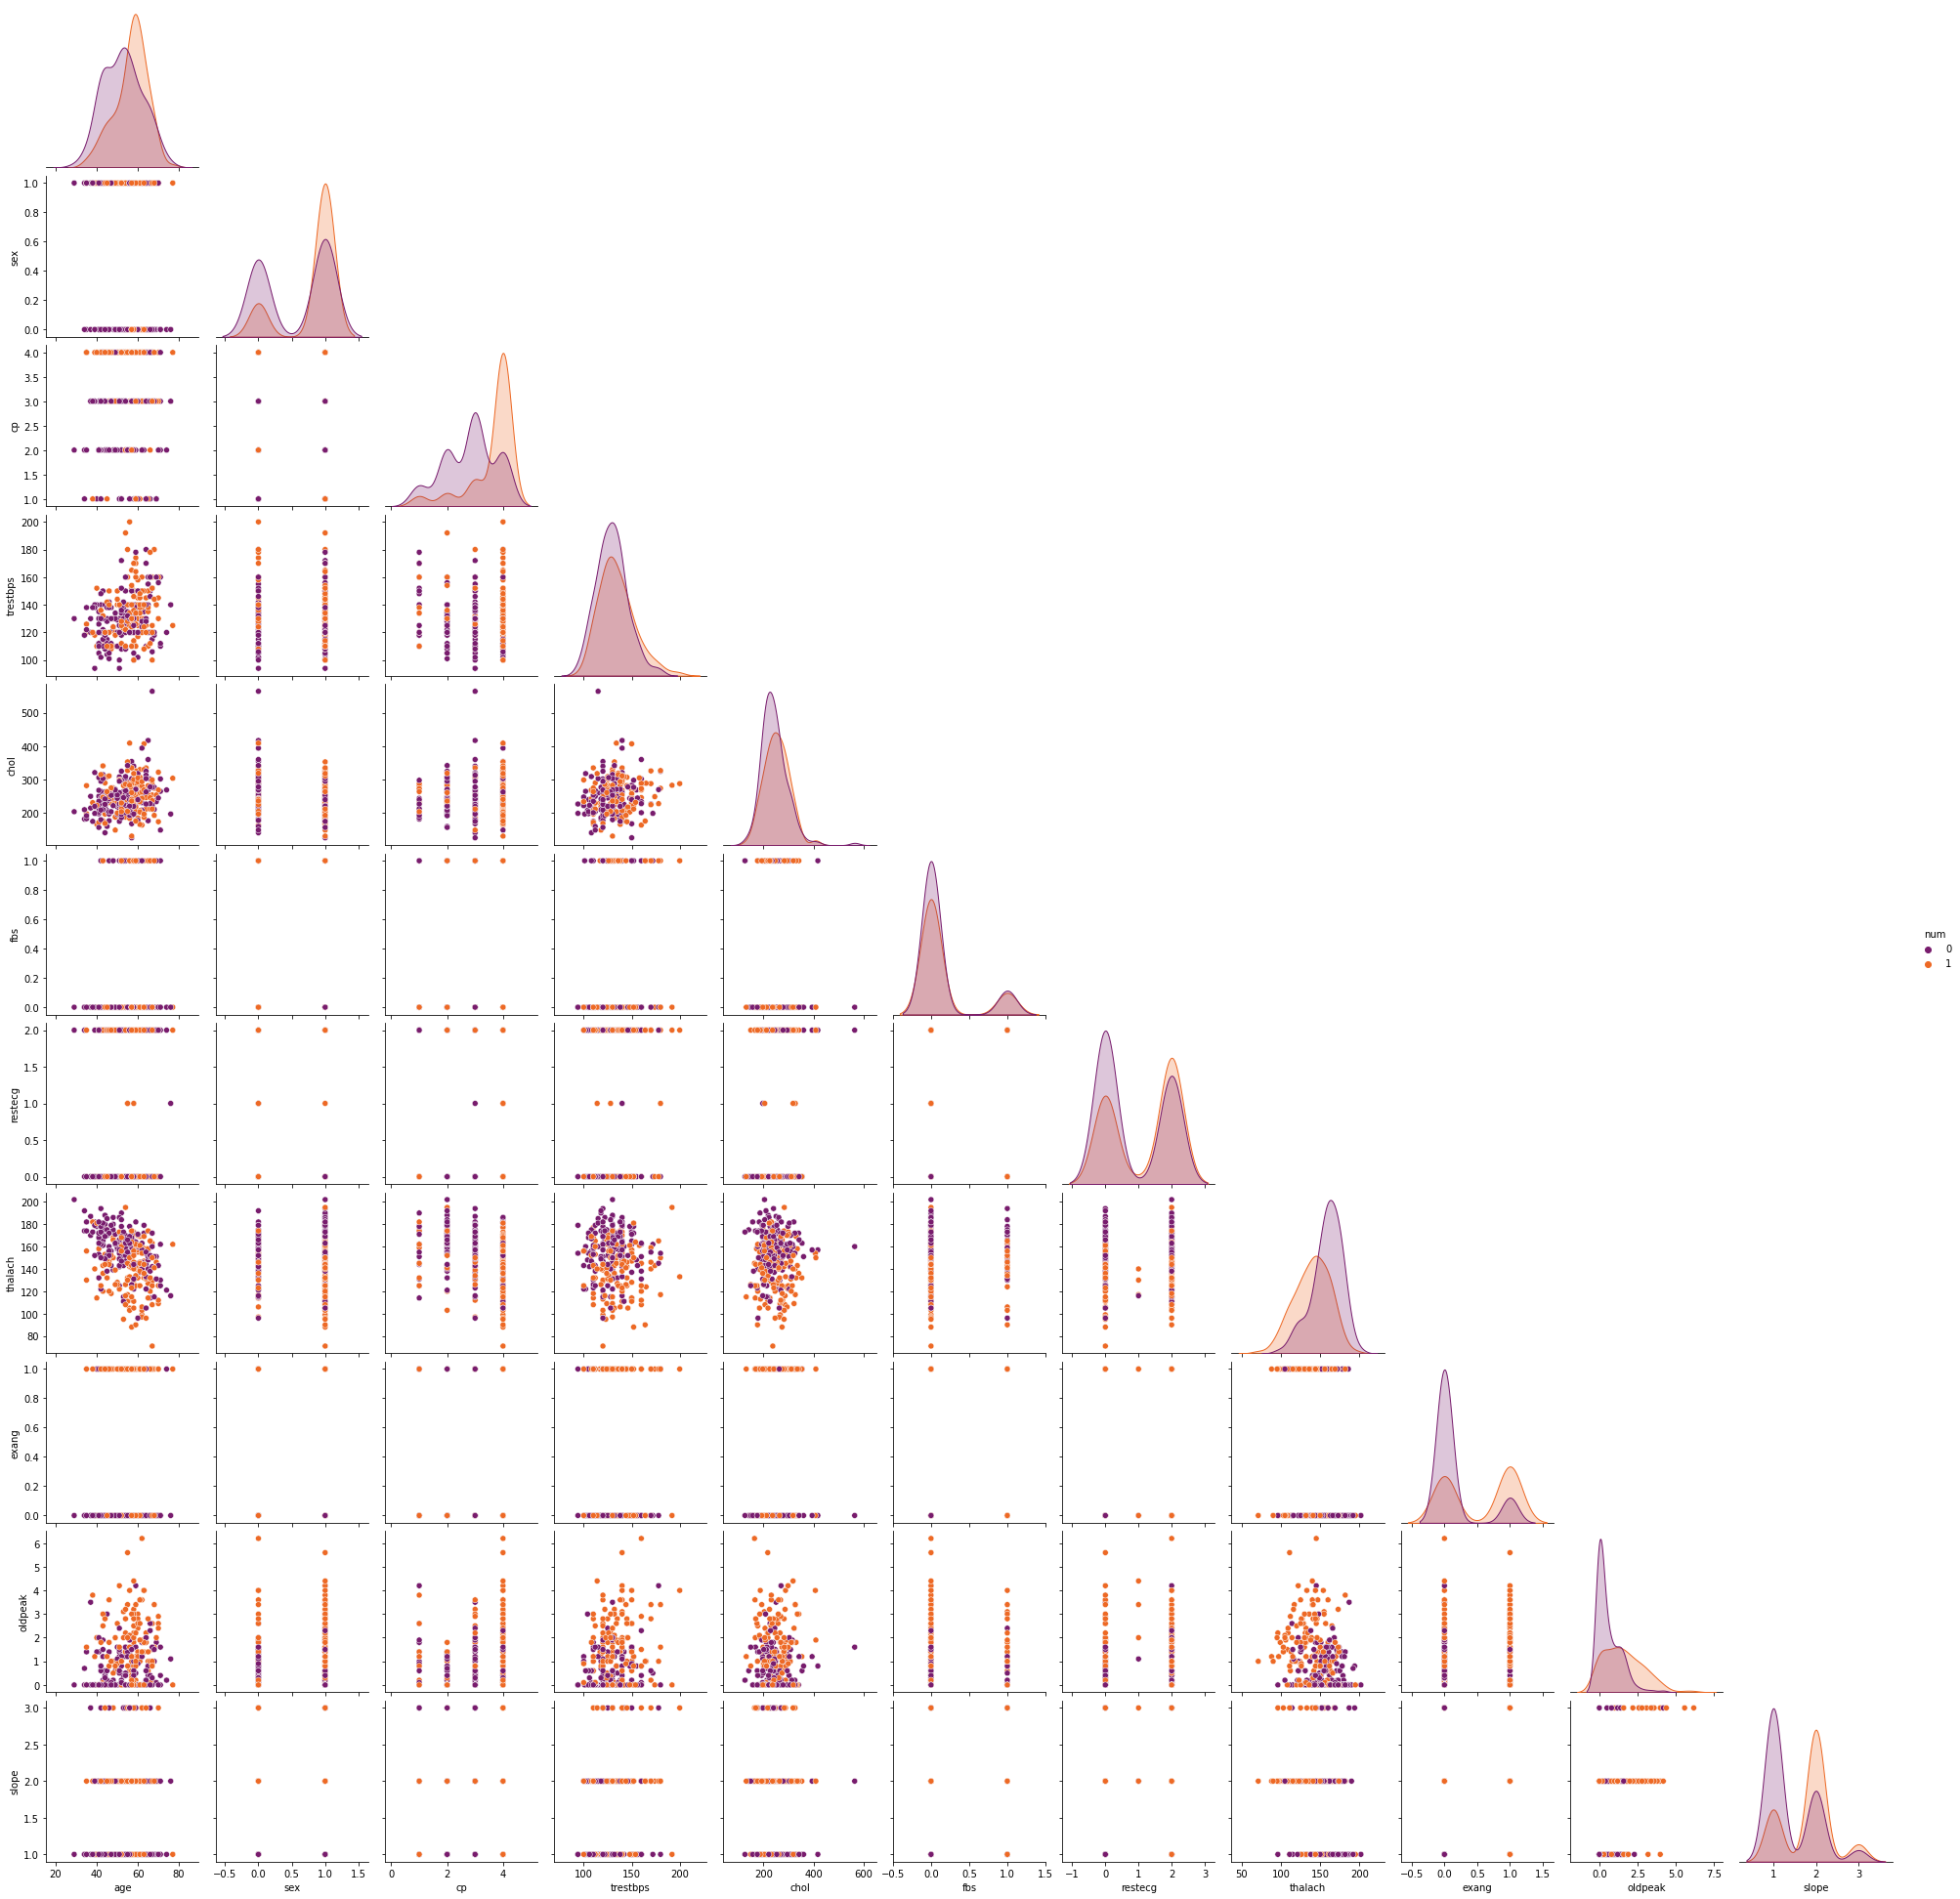

In [9]:
sns.pairplot(df, hue="num", palette="inferno", corner=True);

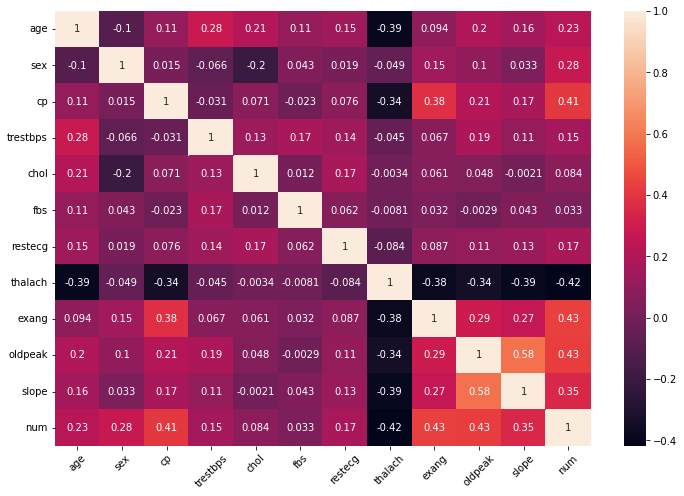

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)
plt.xticks(rotation=45);

In [11]:
df.iplot(kind='hist'); df.iplot(kind='histogram', subplots=True,bins=50)

In [12]:
## K-fold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics

def get_evaluate(va_y, va_pred):
    fpr, tpr, thr_arr = metrics.roc_curve(va_y, va_pred)
    auc = metrics.auc(fpr, tpr)
    precision = metrics.precision_score(va_y, va_pred)
    recall = metrics.recall_score(va_y, va_pred)    
    return auc, precision, recall

N_spl = 4 #データの分割数(eg. 4分割であれば、3つのサブセットは学習に、1個は検証に使う、という学習を4回やる)

auc_s = []
prec_s = []
recall_s = []
log_loss_s = []

models = []
lgb_res = {}

#kf = KFold(n_splits=N_spl, shuffle=True, random_state=1116) #K-fold
#for tr_idx, va_idx in kf.split(train_x):

#Stratified K-fold
kf = StratifiedKFold(n_splits=N_spl, shuffle=True, random_state=1116)
for tr_idx, va_idx in kf.split(train_x, train_y):
  tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
  tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

  # create dataset for lightgbm
  lgb_train = lgb.Dataset(tr_x, tr_y)
  lgb_test = lgb.Dataset(va_x, va_y, reference=lgb_train)
  # LightGBM のハイパーパラメータ
  lgbm_params = {
  # 二値分類問題
  'objective': 'binary',
  # logloss
  'metric': 'binary_logloss',
  }
  model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_test,num_boost_round=1000,early_stopping_rounds=100,evals_result=lgb_res, verbose_eval = False)#verbose_eval=4とすると、4回に1回の割合でmetric(この場合はbinary_logloss)の値がでる
  va_pred_prob = model.predict(va_x, num_iteration=model.best_iteration)
  va_pred = np.round(va_pred_prob,0)
  auc, prec, recal = get_evaluate(va_y, va_pred)
  log_score = metrics.log_loss(va_y,va_pred_prob)
  auc_s.append(auc)
  prec_s.append(prec)
  recall_s.append(recal)
  log_loss_s.append(log_score)
  models.append(model)

#foldスコアの平均値
print('auc=',np.mean(auc_s), 'precision=', np.mean(prec_s), 'recall=',np.mean(recall_s), 'log_loss=',np.mean(log_loss_s))

auc= 0.8238452666376053 precision= 0.8289969834087482 recall= 0.7918346774193549 log_loss= 0.3901519269977389


<Figure size 1440x1440 with 0 Axes>

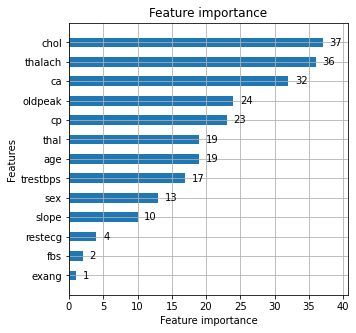

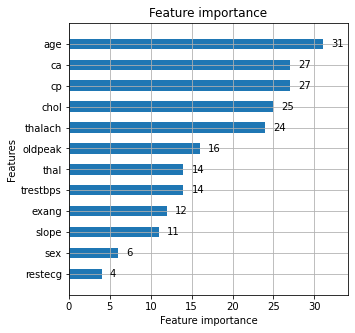

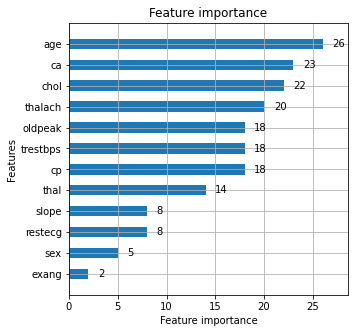

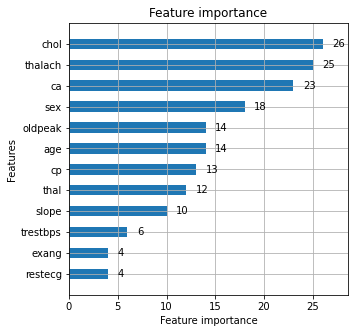

In [13]:
plt.figure(figsize=(20,20))
for i in range(len(models)):
  lgb.plot_importance(models[i], height = 0.5, figsize = (5,5))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


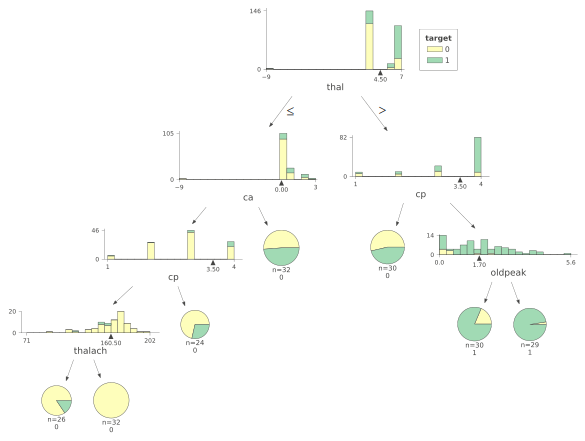

In [14]:
# Load packages
import graphviz
from sklearn import tree

from dtreeviz import trees
from dtreeviz.models.lightgbm_decision_tree import ShadowLightGBMTree

features = train_x.columns

#ここでは最初のモデルを図示する
light_dtree = ShadowLightGBMTree(models[0], tree_index=0, x_data=train_x, y_data=train_y, feature_names=features, target_name="target", class_names=[0,1] )
trees.dtreeviz(light_dtree)

In [15]:
## 試しに、決定木のパスを追いかけてみる
## 
trialPat = 1
x = train_x[train_x.columns].iloc[trialPat]
print(x)

yc = train_y.iloc[trialPat]
print('num=',yc)


age          62.0
sex           1.0
cp            3.0
trestbps    130.0
chol        231.0
fbs           0.0
restecg       0.0
thalach     146.0
exang         0.0
oldpeak       1.8
slope         2.0
ca            3.0
thal          7.0
Name: 91, dtype: float64
num= 0


In [16]:
print(trees.explain_prediction_path(light_dtree, x=x))

cp < 3.5
4.5 <= thal 



In [17]:
##
##  平均方式
## 

def mean_dec(x):
  expect=[]
  for i in range(len(models)):
    expect.append(models[i].predict(x))
  return np.round(np.mean(expect),0)

print("Decision is ",mean_dec(x))

Decision is  1.0


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning:

Converting data to scipy sparse matrix.



In [18]:
##
## 投票方式
##

def votes(x):
  vote = []
  for i in range(len(models)):
    vote.append( np.round(models[i].predict(x),0)  )

  numPosi = vote.count(1)
  numNega = vote.count(0)
  dec = {}
  if numPosi > numNega:
    dec = 1
  else: ##最後のelseを避けるためには、奇数個のモデル構成にすればよい（今の場合なら、K-foldのスプリットの数）
    dec = -1#unclear

  return dec

print("Decision is ", votes(x))

Decision is  1


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning:

Converting data to scipy sparse matrix.



In [19]:
##
## 複数モデルの総合判断

## 新規データ(元データで学習に使っていないデータ)
vote_list = pd.DataFrame(np.arange(len(test_y))   )
for i in range(len(models)):
#  y_pred = models[i].predict(train_x)
  y_pred = models[i].predict(test_x)
  vote_list[i]=y_pred

#vote_list = np.round(vote_list,0)##ここを有効にすると投票方式になる
y_pred=np.round(vote_list.mean(axis=1),0)

In [20]:
# Function for examining scores
def train_val(y_train, y_train_pred):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred)}}
    
    return pd.DataFrame(scores)

## 新規データ(元データで学習に使っていないデータ)
train_val(test_y, np.round(y_pred,0))

,train_set
Accuracy,0.806452
Precision,0.750000
Recall,0.857143
f1,0.800000


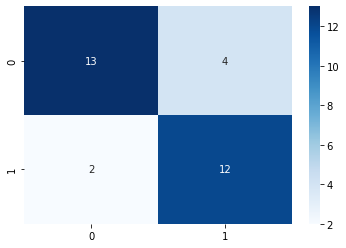

In [21]:
#############################################################
##in binary classification, the count of true negatives is ##
##C_{0,0}, false negatives is C_{1,0}, true positives is   ##
##C_{1,1} and false positives is C_{0,1}.                  ##
#############################################################

#cm = confusion_matrix(train_y, np.round(y_pred,0))

## 新規データ
cm = confusion_matrix(test_y, np.round(y_pred,0))
sns.heatmap(cm, annot=True, cmap='Blues')

In [22]:
## fbs値を落としてみる
mush_x = train_x.drop(['fbs'], axis=1)

In [23]:
## K-fold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics

def get_evaluate(va_y, va_pred):
    fpr, tpr, thr_arr = metrics.roc_curve(va_y, va_pred)
    auc = metrics.auc(fpr, tpr)
    precision = metrics.precision_score(va_y, va_pred)
    recall = metrics.recall_score(va_y, va_pred)    
    return auc, precision, recall

N_spl = 4 #データの分割数(eg. 4分割であれば、3つのサブセットは学習に、1個は検証に使う、という学習を4回やる)

auc_s = []
prec_s = []
recall_s = []
log_loss_s = []

models = []
lgb_res = {}

#kf = KFold(n_splits=N_spl, shuffle=True, random_state=1116) #K-fold
#for tr_idx, va_idx in kf.split(train_x):

#Stratified K-fold
kf = StratifiedKFold(n_splits=N_spl, shuffle=True, random_state=1116)
for tr_idx, va_idx in kf.split(mush_x, train_y):
  tr_x, va_x = mush_x.iloc[tr_idx], mush_x.iloc[va_idx]
  tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

  # create dataset for lightgbm
  lgb_train = lgb.Dataset(tr_x, tr_y)
  lgb_test = lgb.Dataset(va_x, va_y, reference=lgb_train)
  # LightGBM のハイパーパラメータ
  lgbm_params = {
  # 二値分類問題
  'objective': 'binary',
  # logloss
  'metric': 'binary_logloss',
  }
  model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_test,num_boost_round=1000,early_stopping_rounds=100,evals_result=lgb_res, verbose_eval = False)#verbose_eval=4とすると、4回に1回の割合でmetric(この場合はbinary_logloss)の値がでる
  va_pred_prob = model.predict(va_x, num_iteration=model.best_iteration)
  va_pred = np.round(va_pred_prob,0)
  auc, prec, recal = get_evaluate(va_y, va_pred)
  log_score = metrics.log_loss(va_y,va_pred_prob)
  auc_s.append(auc)
  prec_s.append(prec)
  recall_s.append(recal)
  log_loss_s.append(log_score)
  models.append(model)

#foldスコアの平均値
print('auc=',np.mean(auc_s), 'precision=', np.mean(prec_s), 'recall=',np.mean(recall_s), 'log_loss=',np.mean(log_loss_s))

auc= 0.8238452666376053 precision= 0.8289969834087482 recall= 0.7918346774193549 log_loss= 0.3910323057080181


<Figure size 1440x1440 with 0 Axes>

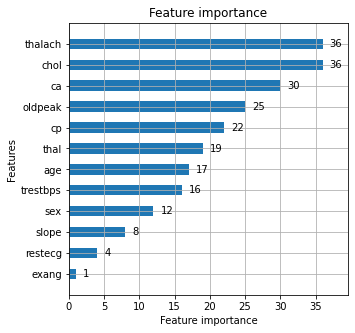

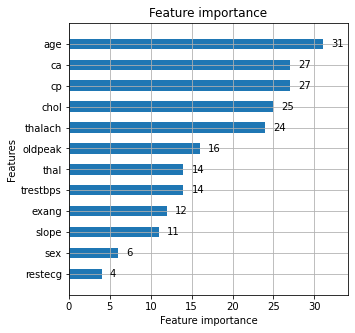

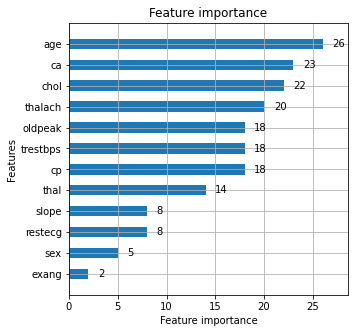

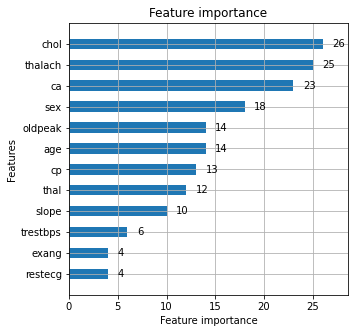

In [24]:
plt.figure(figsize=(20,20))
for i in range(len(models)):
  lgb.plot_importance(models[i], height = 0.5, figsize = (5,5))

In [25]:
mush_test_x = test_x.drop(['fbs'],axis=1)

In [26]:
##
## 複数モデルの総合判断
##
vote_list = pd.DataFrame(np.arange(len(test_y))   )
for i in range(len(models)):
  y_pred = models[i].predict(mush_test_x)
  vote_list[i]=y_pred

#vote_list = np.round(vote_list,0)##この行を有効にすると、投票方式になる
y_pred=np.round(vote_list.mean(axis=1),0)

In [27]:
train_val(test_y, np.round(y_pred,0))

,train_set
Accuracy,0.806452
Precision,0.750000
Recall,0.857143
f1,0.800000


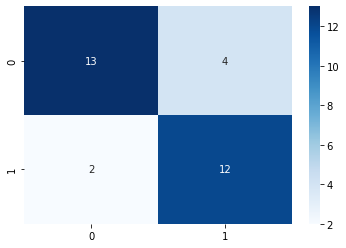

In [28]:
## 
cm = confusion_matrix(test_y, np.round(y_pred,0))
sns.heatmap(cm, annot=True, cmap='Blues')

In [29]:
#ここでは2番目のモデルを図示する
features = mush_test_x.columns
light_dtree = ShadowLightGBMTree(models[1], tree_index=0, x_data=mush_test_x, y_data=test_y, feature_names=features, target_name="target", class_names=[0,1] )

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



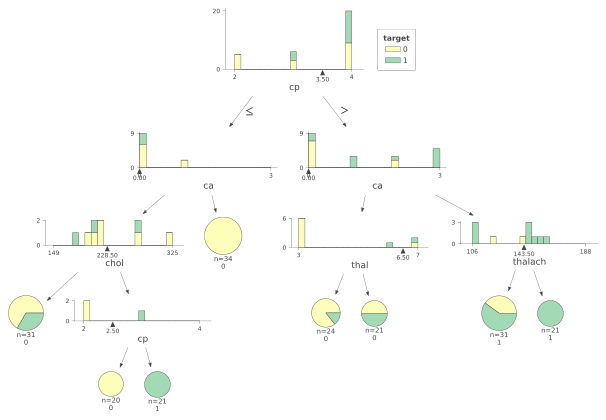

In [30]:
trees.dtreeviz(light_dtree)